In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import matplotlib.ticker as mtick

In [4]:

# get param set
paramsets =  pd.read_csv('../../output_random_rows.csv')
paramsets = paramsets.drop(paramsets.columns.tolist()[-1],axis=1)
paramsets.drop('theta',inplace=True, axis=1)
paramsets.drop('ro_B',inplace=True, axis=1)
paramsets.drop('k_sorp',inplace=True, axis=1)
paramsets.drop('CSS_max',inplace=True, axis=1)
selectedSets = [ 1, 12, 19, 22, 26, 30, 51, 54, 58, 63, 67, 68, 71, 72, 73, 77, 81,
       85, 90, 94]
paramsets['Pset']= [i for i in range(99)]
#paramsets = paramsets.loc[[19, 47, 76, 83]]#paramsets.loc(selectedSets)

In [5]:
print(min(paramsets['CS_init']),max(paramsets['CS_init']))

0.001096675 0.090675274


In [6]:
repr(paramsets.columns.tolist())

"['beta_C', 'beta_O', 'C_thres,C', 'C_thres,O', 'DS_W', 'k_C,S', 'k_d,C', 'k_d,O', 'K_L', 'k_O,S', 'k_r,C', 'k_r,O', 'm_max,C', 'm_max,O', 'p_L', 'u_max,C', 'u_max,O', 'v_max,L', 'Y', 'Y_C', 'Y_O', 'CL_init', 'CS_init', 'Pset']"

In [7]:
def getuVar(paramsetsall,Iloc):
    paramsets = paramsetsall.iloc[Iloc]
    paramsets_ = pd.DataFrame()
    # mol/cm3 * [g/mol] * [mg/g]
    C_aInitO = 9.16666666666667e-07 * 12 * 1000
    C_dInitO = 8.33333333333333e-06 * 12 * 1000
    C_aInitC = 8.33333333333333e-07 * 12 * 1000
    C_dInitC = 8.33333333333333e-06 * 12 * 1000

    kads = 7.07e+02 # m3/kgC/yr, see 10.1016/j.soilbio.2020.107912, A.3
    yr_per_d = 1/365 # [yr/d]
    m3_per_cm3 = 1e-6; # m3/cm3
    cm3_per_m3 = 1e6; # cm3/m3
    mg_per_kgC = 1e6 # mg/kg
    # [m3/kgC/yr] * [yr/d] * [cm3/m3] * [kgC/mg] = [cm3/mg/d]
    kads = kads * yr_per_d * cm3_per_m3 * mg_per_kgC
    kdes =  1.63e+03 # [1/yr] see 10.1016/j.soilbio.2020.107912, A.3
    kdes = kdes * yr_per_d # [1/d]
    # mol/cm3_soil / [cm3_w/cm3_soil] * mgC/molC = mgC/cm3water
    maxCs = 0.4#max(paramsetsall['CS_init'])*10
    CS_init = np.arange(0,maxCs, maxCs/1000)

    # C_thresC, C_thresO, CS_init have strong correlation
    # mgC/cm3 water

    # O
    paramsets_['CS_init'] = CS_init
    paramsets_['phiO'] = 1/(1 + np.exp((paramsets['C_thres,O'] - CS_init)/(0.1 * paramsets['C_thres,O'])))

    paramsets_['S_deactO']  = (1 - paramsets_['phiO'] ) * paramsets['k_d,O']  * C_aInitO
    paramsets_['S_reactO']  = paramsets_['phiO']  *  paramsets['k_r,O']  * C_dInitO
    paramsets_['S_uptake_S_AO'] = (paramsets['m_max,O'] * CS_init * paramsets['k_O,S'])/(paramsets['m_max,O'] + CS_init * paramsets['k_O,S']) * C_aInitO
    paramsets_['S_uptake_S_DO'] = (paramsets['m_max,O'] * CS_init * paramsets['k_O,S']
                                  )/(paramsets['m_max,O'] + CS_init * paramsets['k_O,S']) * paramsets['beta_O'] * C_dInitO

    paramsets_['S_decay_AO'] = paramsets['m_max,O'] * C_aInitO  - paramsets_['S_uptake_S_AO'] 
    paramsets_['S_decay_DO'] = paramsets['m_max,O'] * paramsets['beta_O']  * C_dInitO - paramsets_['S_uptake_S_DO'] 

    paramsets_['S_growthO'] = (paramsets['u_max,O'] * CS_init * paramsets['k_O,S'])/(paramsets['u_max,O'] + CS_init * paramsets['k_O,S']) * C_aInitO

    # sum
    paramsets_['S_uptake_S'] = paramsets_['S_uptake_S_AO'] + paramsets_['S_uptake_S_DO']
    paramsets_['S_decay'] = paramsets_['S_decay_AO'] + paramsets_['S_decay_DO']
    paramsets_['S_growth'] = paramsets_['S_growthO'] #(1/paramsets['Y_O']) * 

    # C
    paramsets_['phiC'] = 1/(1 + np.exp((paramsets['C_thres,C'] - CS_init)/(0.1 *paramsets['C_thres,C'])))

    paramsets_['S_deactC']  = (1 - paramsets_['phiC'] ) * paramsets['k_d,C']  * C_aInitC
    paramsets_['S_reactC']  = paramsets_['phiC']  *  paramsets['k_r,C']  * C_dInitC

    paramsets_['S_uptake_S_AC'] = (paramsets['m_max,C'] * CS_init * paramsets['k_C,S'])/(paramsets['m_max,C'] + CS_init * paramsets['k_C,S']) * C_aInitO
    paramsets_['S_uptake_S_DC'] = (paramsets['m_max,C'] * CS_init * paramsets['k_C,S']
                                  )/(paramsets['m_max,C'] + CS_init * paramsets['k_C,S']) * paramsets['beta_C'] * C_dInitO 

    paramsets_['S_decay_AC'] = paramsets['m_max,C'] * C_aInitO  - paramsets_['S_uptake_S_AC']
    paramsets_['S_decay_DC'] = paramsets['m_max,C'] * paramsets['beta_C']  * C_dInitO  - paramsets_['S_uptake_S_DC'] 

    paramsets_['S_growthC'] = (paramsets['u_max,C'] * CS_init * paramsets['k_C,S'])/(paramsets['u_max,C'] + CS_init * paramsets['k_C,S']) * C_aInitO 

    # sum
    paramsets_['S_uptake_S'] += paramsets_['S_uptake_S_AC'] + paramsets_['S_uptake_S_DC']
    paramsets_['S_decay'] += paramsets_['S_decay_AC'] + paramsets_['S_decay_DC']
    paramsets_['S_growth'] += paramsets_['S_growthC'] #(1/paramsets['Y_C']) * 

    # microb
    # add CSinit/CSSMax

    paramsets_['dCoAdt'] = (paramsets_['S_growthO'] - paramsets_['S_deactO']  + paramsets_['S_reactO'] - (1/paramsets['Y'])*paramsets_['S_decay_AO'])
    paramsets_['dCoDdt'] = (paramsets_['S_deactO']  - paramsets_['S_reactO'] - (1/paramsets['Y'])*paramsets_['S_decay_DO'])
    paramsets_['dCcAdt'] = (paramsets_['S_growthC'] - paramsets_['S_deactC']  + paramsets_['S_reactC'] - (1/paramsets['Y'])*paramsets_['S_decay_AC'] ) 
    paramsets_['dCcDdt'] = (paramsets_['S_deactC'] - paramsets_['S_reactC'] - (1/paramsets['Y'])*paramsets_['S_decay_DC'] ) 
    paramsets_['dCO2dt'] = (((1-paramsets['Y_O'])/paramsets['Y_O']
                            )*paramsets_['S_growthO'] +((1-paramsets['Y_C'])/paramsets['Y_C']
                                                       )*paramsets_['S_growthC'] +((1-paramsets['Y'])/paramsets['Y']
                                                                                  )*paramsets_['S_decay']+ paramsets_['S_uptake_S'])

    #paramsets_['CSW/CSS'] =( CS_init+ (kdes/kads))/paramsets['CSS_max']

    df = pd.DataFrame()
    df['CS_init']=paramsets_['CS_init']
    df['phiO'] = paramsets_['phiO']
    df['phiC'] = paramsets_['phiC']
    df['phiC/phiO'] = df['phiC']/df['phiO']
    #df['S_growth_O/S_decay_O'] = paramsets_['S_growthO']/((1/paramsets['Y'])*paramsets_['S_decay_DO'] + (1/paramsets['Y'])*paramsets_['S_decay_AO'])
    #df['S_growth_C/S_decay_C'] =  paramsets_['S_growthC']/((1/paramsets['Y'])*paramsets_['S_decay_DC'] + (1/paramsets['Y'])*paramsets_['S_decay_AC'])
    #df['(S_growth_O/S_decay_O)/(S_growth_C/S_decay_C)'] =(paramsets_['S_growthC']/((1/paramsets['Y'])*paramsets_['S_decay_DC'] + (1/paramsets['Y'])*paramsets_['S_decay_AC']))/(paramsets_['S_growthO']/((1/paramsets['Y'])*paramsets_['S_decay_DO'] + (1/paramsets['Y'])*paramsets_['S_decay_AO']))
    df['S_decay_O/S_growth_O'] = 1/(paramsets_['S_growthO']/((1/paramsets['Y'])*paramsets_['S_decay_DO'] + 
                                                             (1/paramsets['Y'])*paramsets_['S_decay_AO']))
    df['S_decay_C/S_growth_C'] =  1/(paramsets_['S_growthC']/((1/paramsets['Y'])*paramsets_['S_decay_DC'] + 
                                                              (1/paramsets['Y'])*paramsets_['S_decay_AC']))
    df['(S_decay_O/S_growth_O)/(S_decay_C/S_growth_C)'] =(1/(paramsets_['S_growthC']/((1/paramsets['Y'])*paramsets_['S_decay_DC'] + 
                                                                                     (1/paramsets['Y'])*paramsets_['S_decay_AC'])))/(
        1/(paramsets_['S_growthO']/((1/paramsets['Y'])*paramsets_['S_decay_DO'] + 
                                    (1/paramsets['Y'])*paramsets_['S_decay_AO'])))
    df['S_deactC/S_reactC'] = paramsets_['S_deactC'] / paramsets_['S_reactC'] 
    df['S_deactO/S_reactO'] = paramsets_['S_deactO'] / paramsets_['S_reactO'] 
    df['(S_deactO/S_reactO)/(S_deactC/S_reactC)'] =( paramsets_['S_deactO'] / paramsets_['S_reactO'])/(paramsets_['S_deactC'] / paramsets_['S_reactC'] ) 
    #df['d(Cs->MB)dt/d(MB->Cs)dt'] = (paramsets_['S_uptake_S'] + paramsets_['S_growth_S'])/ ((1 - paramsets['p_L'])*paramsets_['S_decay'])  # 'S_decay/(S_uptake_S+ S_growth_S)']
    #df['d(MB_C->C)dt/d(C->MB_C)dt'] = ( (1/paramsets['Y'])*paramsets_['S_decay_AO']+(1/paramsets['Y'])*paramsets_['S_decay_DO'])/(paramsets_['S_uptake_S'] + paramsets_['S_growthO']) 
    #df['d(MB_O->C)dt/d(C->MB_O)dt'] = ( (1/paramsets['Y'])*paramsets_['S_decay_AC']+(1/paramsets['Y'])*paramsets_['S_decay_DC'])/(paramsets_['S_uptake_S'] + paramsets_['S_growthC']) 
    #df['d(MB->C)dt/d(Cs->MB)dt'] = ( (1/paramsets['Y'])* paramsets_['S_decay'])/(paramsets_['S_growth'])  # 'S_decay/(S_uptake_S+ S_growth_S)']

    #df['(S_uptakeC + S_growthC)/(S_uptakeO + S_growthO)'] = (paramsets_['S_uptake_S_AC']+ paramsets_['S_uptake_S_DC'] +  paramsets_['S_growthC'])/ ( paramsets_['S_uptake_S_AO'] + paramsets_['S_uptake_S_DO'] +  paramsets_['S_growthO'])

    #df['dCoAdt/dCoDdt'] = paramsets_['dCoAdt']/paramsets_['dCoDdt']
    #df['dCcAdt/dCcDdt'] = paramsets_['dCcAdt']/paramsets_['dCcDdt'] 
    #df['(dCoAdt + dCcAdt)/(dCoDdt + dCcDdt)'] = (paramsets_['dCoAdt'] + paramsets_['dCcAdt'])/ (paramsets_['dCoDdt'] + paramsets_['dCcDdt'] ) 
    df['(S_growth_O + S_decay_O)/(S_deactO+S_reactO)'] = (paramsets_['S_growthO'] + (1/paramsets['Y'])*paramsets_['S_decay_AO'] + (1/paramsets['Y'])*paramsets_['S_decay_DO']
                                                         )/( paramsets_['S_deactO'] + paramsets_['S_reactO'] )
    df['(S_growth_C + S_decay_C)/(S_deactC+S_reactC)'] = (paramsets_['S_growthC'] + (1/paramsets['Y'])*paramsets_['S_decay_AC'] + (1/paramsets['Y'])*paramsets_['S_decay_DC']
                                                         )/( paramsets_['S_deactC'] + paramsets_['S_reactC'] )
    df['dCO2dt/abs(dMBdt)'] = paramsets_['dCO2dt']/(abs(paramsets_['dCoAdt'])+abs(paramsets_['dCoDdt'])+abs(paramsets_['dCcAdt'])+abs(paramsets_['dCcDdt']))
    #df['CSW/CSS'] = paramsets_['CSW/CSS']
    
    return df
    # deact + react / growth + decay <= what causes turnover
    # growth / decay

In [8]:
#getuVar(paramsets,0)

In [9]:
paramsets.shape[0]

99

In [10]:
alldfs = []
for pset in range(paramsets.shape[0]):
    dS_ = getuVar(paramsets,pset)
    dS_['Pset'] = pset
    alldfs.append(dS_)#paramsets.iloc[pset])
print(len(alldfs),alldfs[0].shape)

concatenated_df = pd.concat(alldfs, ignore_index=True)

99 (1000, 14)


[]

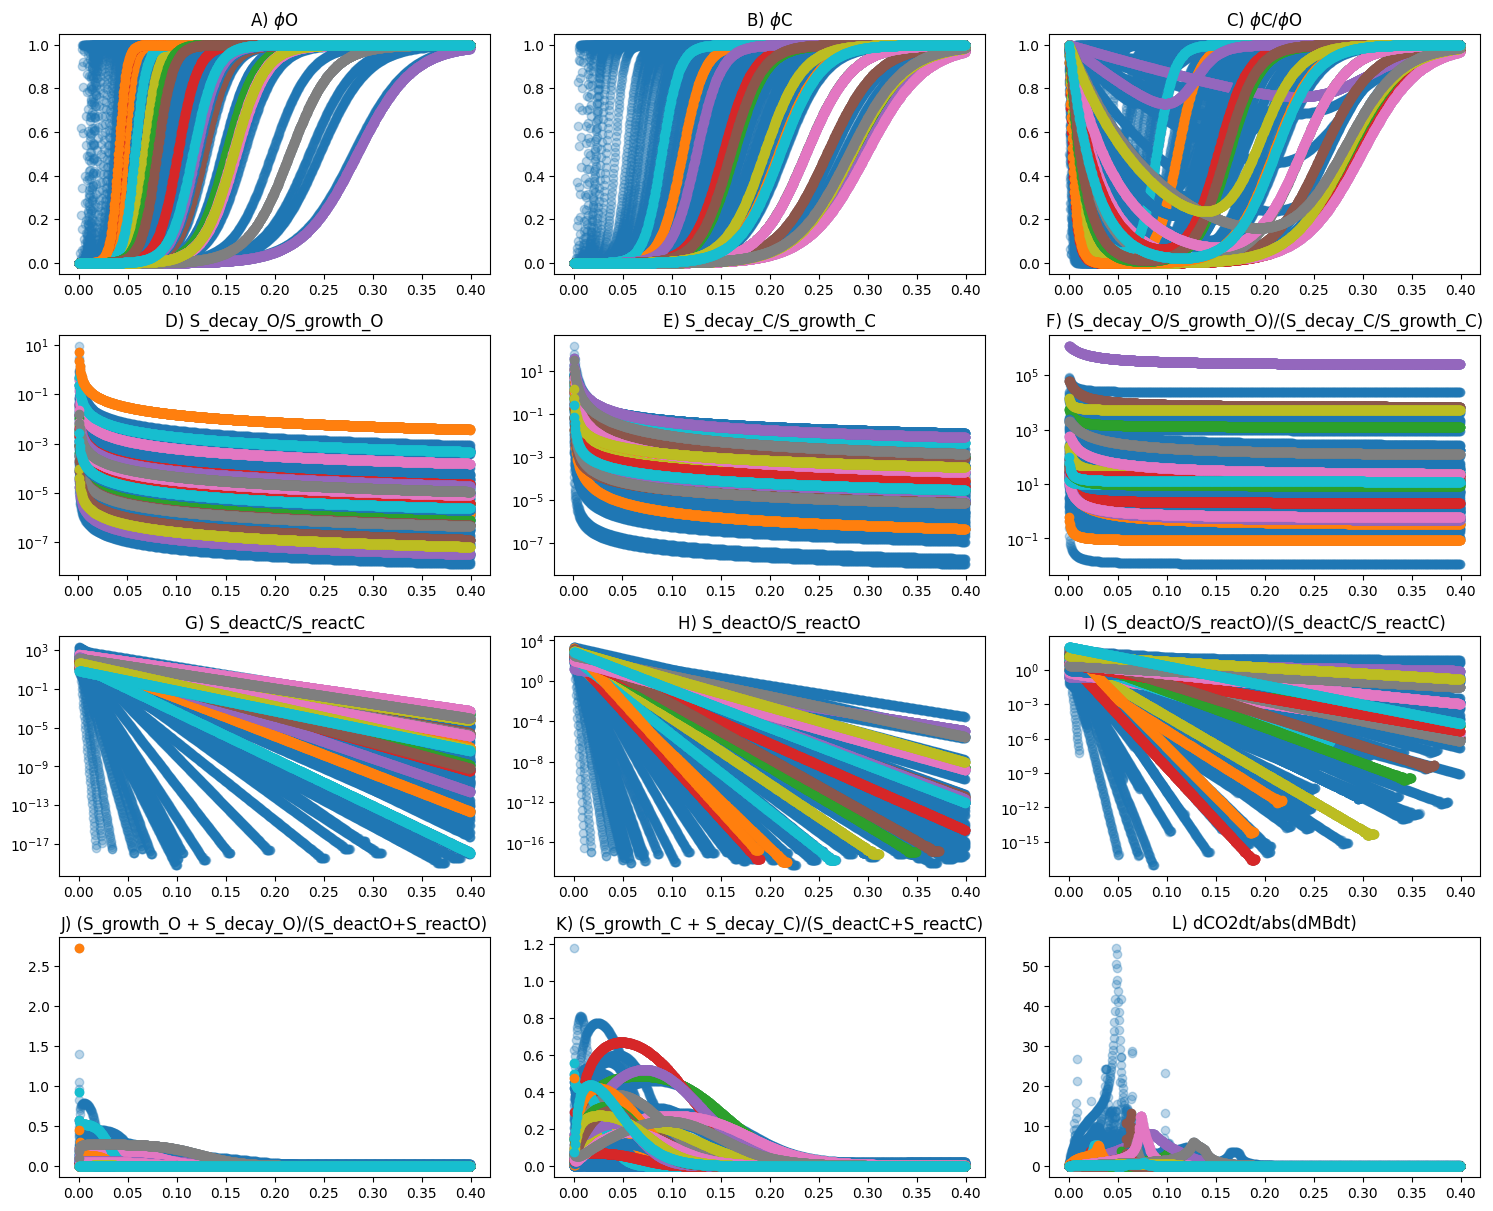

In [15]:
from matplotlib import colors
import seaborn as sns
rgb_values = ['tab:blue','tab:orange','tab:green','tab:red',
              'tab:purple','tab:brown','tab:pink','tab:gray',
              'tab:olive','tab:cyan']*2#sns.color_palette("Set2", 4)
color_map = dict(zip(selectedSets,rgb_values))

toEval = concatenated_df

# Create subplots grid

# Calculate the number of rows and columns needed for subplots
num_rows = 6
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 18))

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

#outliers = selectedSets
# Plot histograms for each column
for i, column in enumerate(toEval.columns[1:]):
    if column != 'Pset':
        ax = axes[i]  # Get the current axis
        columnTitle = column.replace("phi", r'$\phi$')
        
        ax.set_title(chr(ord('@')+i+1)+") "+columnTitle)
        ax.scatter((toEval['CS_init']),toEval[column], alpha=0.3, 
                    #zorder=100,#label=f'{vall}'
                   )
        for vall in selectedSets:
            subset = toEval[toEval['Pset'] == vall]  # Select subset where 'pSet' equals the current value
            col = color_map[vall]
            col = colors.to_hex(col)
            ax.scatter((subset['CS_init']),subset[column], alpha=1, 
                    zorder=100,label=f'{vall}', 
                       c=col
                   )
            if ('S_deactC/' in column) or ('S_deactO/' in column) or ('/S_growth_C' in column) or ('/S_growth_O' in column):
                ax.set_yscale('log')
            #if i == 0:
            #    ax.legend()
    
# Remove any empty subplots if the number of columns exceeds the number of data columns
for i in range(len(toEval.columns)-2, num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.plot()

In [16]:
color_map

{1: 'tab:blue',
 12: 'tab:orange',
 19: 'tab:green',
 22: 'tab:red',
 26: 'tab:purple',
 30: 'tab:brown',
 51: 'tab:pink',
 54: 'tab:gray',
 58: 'tab:olive',
 63: 'tab:cyan',
 67: 'tab:blue',
 68: 'tab:orange',
 71: 'tab:green',
 72: 'tab:red',
 73: 'tab:purple',
 77: 'tab:brown',
 81: 'tab:pink',
 85: 'tab:gray',
 90: 'tab:olive',
 94: 'tab:cyan'}

In [ ]:

toEval = concatenated_df

# Create subplots grid

# Calculate the number of rows and columns needed for subplots
num_rows = 6
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 18))

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

#outliers = selectedSets
# Plot histograms for each column
for i, column in enumerate(toEval.columns[1:]):
    if column != 'Pset':
        ax = axes[i]  # Get the current axis
        columnTitle = column.replace("phi", r'$\phi$')
        
        ax.set_title(chr(ord('@')+i+1)+") "+columnTitle)
        #ax.scatter((toEval['CS_init']),toEval[column], alpha=0.3, 
        #            #zorder=100,#label=f'{vall}'
        #           )
        for vall in selectedSets:
            subset = toEval[toEval['Pset'] == vall]  # Select subset where 'pSet' equals the current value
            col = color_map[vall]
            col = colors.to_hex(col)
            ax.scatter((subset['CS_init']),subset[column], alpha=1, 
                    zorder=100,label=f'{vall}', 
                       c=col
                   )
            if ('S_deactC/' in column) or ('S_deactO/' in column) or ('/S_growth_C' in column) or ('/S_growth_O' in column):
                ax.set_yscale('log')
            if i == 0:
                ax.legend()
    
# Remove any empty subplots if the number of columns exceeds the number of data columns
for i in range(len(toEval.columns)-2, num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.plot()